In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## 1. Loading the datasets

In [2]:
train = pd.read_csv("/content/test.csv")
X_train, y_train = train['message'], train.label

test = pd.read_csv("/content/test.csv")
X_test, y_test = test['message'], test.label

val = pd.read_csv("/content/val.csv")
X_val, y_val = val['message'], val.label

### Vectorize the data

In [4]:
# Remove any nan value
X_train = X_train.fillna("")
X_val = X_val.fillna("")
X_test = X_test.fillna("")

vectorizer = TfidfVectorizer(strip_accents='unicode')

# Fit on training data and transform all sets
X_train_vec = vectorizer.fit_transform(X_train.astype(str))
X_val_vec = vectorizer.transform(X_val.astype(str))
X_test_vec = vectorizer.transform(X_test.astype(str))

In [6]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


## Training three different base models

In [7]:
# Logistic regression
lr_pipeline = Pipeline([('balance', SMOTE(random_state=42)),
                        ('model', LogisticRegression(random_state=42))])
lr_pipeline.fit(X_train_vec, y_train)
lr_val_preds = lr_pipeline.predict(X_val_vec)
lr_train_preds = lr_pipeline.predict(X_train_vec)

print("Logistic Regression train Performance:")
print(classification_report(y_train, lr_train_preds))
print('='*60)
print("Logistic Regression Validation Performance:")
print(classification_report(y_val, lr_val_preds))

Logistic Regression train Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       677
           1       0.99      0.99      0.99        98

    accuracy                           1.00       775
   macro avg       0.99      0.99      0.99       775
weighted avg       1.00      1.00      1.00       775

Logistic Regression Validation Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       677
           1       0.89      0.83      0.86        98

    accuracy                           0.97       775
   macro avg       0.93      0.91      0.92       775
weighted avg       0.96      0.97      0.96       775



In [8]:
# Random Forest
rf_pipeline = Pipeline([('balance', SMOTE(random_state=42)),
                        ('model', RandomForestClassifier(random_state=42))])
rf_pipeline.fit(X_train_vec, y_train)
rf_val_preds = rf_pipeline.predict(X_val_vec)
rf_train_preds = rf_pipeline.predict(X_train_vec)

print("Random Forest train Performance:")
print(classification_report(y_train, rf_train_preds))
print('='*60)
print("Random Forest Validation Performance:")
print(classification_report(y_val, rf_val_preds))


Random Forest train Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       677
           1       1.00      1.00      1.00        98

    accuracy                           1.00       775
   macro avg       1.00      1.00      1.00       775
weighted avg       1.00      1.00      1.00       775

Random Forest Validation Performance:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       677
           1       1.00      0.45      0.62        98

    accuracy                           0.93       775
   macro avg       0.96      0.72      0.79       775
weighted avg       0.94      0.93      0.92       775



In [9]:
# SVM
svm_pipeline = Pipeline([('balance', SMOTE(random_state=42)),
                         ('model', SVC(probability=True, random_state=42))])
svm_pipeline.fit(X_train_vec, y_train)
svm_val_preds = svm_pipeline.predict(X_val_vec)
svm_train_preds = svm_pipeline.predict(X_train_vec)

print("SVM train Performance:")
print(classification_report(y_train, svm_train_preds))
print('='*60)
print("SVM Validation Performance:")
print(classification_report(y_val, svm_val_preds))

SVM train Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       677
           1       1.00      1.00      1.00        98

    accuracy                           1.00       775
   macro avg       1.00      1.00      1.00       775
weighted avg       1.00      1.00      1.00       775

SVM Validation Performance:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97       677
           1       0.98      0.51      0.67        98

    accuracy                           0.94       775
   macro avg       0.96      0.75      0.82       775
weighted avg       0.94      0.94      0.93       775



## Tuning the models

In [10]:
# Define hyperparameter grids
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [11]:
grid_svm = GridSearchCV(SVC(), param_grid_svm, scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_svm.fit(X_val_vec, y_val)
best_svm = grid_svm.best_estimator_
print("Best SVM Parameters:", grid_svm.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [12]:
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_rf.fit(X_val_vec, y_val)
best_rf = grid_rf.best_estimator_
print("Best Random Forest Parameters:", grid_rf.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [13]:
grid_lr = GridSearchCV(LogisticRegression(), param_grid_lr, scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_lr.fit(X_val_vec, y_val)
best_lr = grid_lr.best_estimator_
print("Best Logistic Regression Parameters:", grid_lr.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


## Prediction on the validation and test set using tuned model

In [14]:
# Get predictions on validation
y_pred_lr = best_lr.predict(X_test_vec)
y_pred_svm = best_svm.predict(X_test_vec)
y_pred_rf = best_rf.predict(X_test_vec)


In [15]:
# SVM model
svm_val_preds = best_svm.predict(X_val_vec)

print("Tuned SVM validation Performance:")
print(classification_report(y_train, svm_val_preds))
print('='*60)
print("Best SVM test Performance:")
print(classification_report(y_test, y_pred_svm))

Tuned SVM validation Performance:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       677
           1       0.13      0.13      0.13        98

    accuracy                           0.78       775
   macro avg       0.50      0.50      0.50       775
weighted avg       0.78      0.78      0.78       775

Best SVM test Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       677
           1       0.97      0.78      0.86        98

    accuracy                           0.97       775
   macro avg       0.97      0.89      0.92       775
weighted avg       0.97      0.97      0.97       775



In [16]:
# Logistic Regression model
lr_val_preds = best_lr.predict(X_val_vec)

print("Tuned lr validation Performance:")
print(classification_report(y_train, lr_val_preds))
print('='*60)
print("Best lr test Performance:")
print(classification_report(y_test, y_pred_lr))

Tuned lr validation Performance:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       677
           1       0.13      0.13      0.13        98

    accuracy                           0.78       775
   macro avg       0.50      0.50      0.50       775
weighted avg       0.78      0.78      0.78       775

Best lr test Performance:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       677
           1       1.00      0.68      0.81        98

    accuracy                           0.96       775
   macro avg       0.98      0.84      0.89       775
weighted avg       0.96      0.96      0.96       775



In [17]:
# Random Forest model
rf_val_preds = best_svm.predict(X_val_vec)

print("Tuned RF validation Performance:")
print(classification_report(y_train, rf_val_preds))
print('='*60)
print("Best RF test Performance:")
print(classification_report(y_test, y_pred_rf))

Tuned RF validation Performance:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       677
           1       0.13      0.13      0.13        98

    accuracy                           0.78       775
   macro avg       0.50      0.50      0.50       775
weighted avg       0.78      0.78      0.78       775

Best RF test Performance:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       677
           1       1.00      0.64      0.78        98

    accuracy                           0.95       775
   macro avg       0.98      0.82      0.88       775
weighted avg       0.96      0.95      0.95       775



### We see SVM model scores highest on our testing data

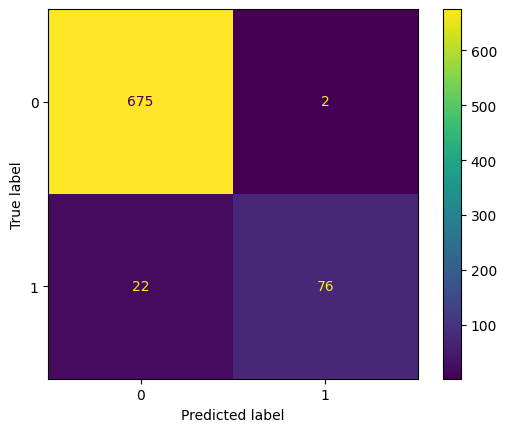

In [22]:
ConfusionMatrixDisplay.from_estimator(best_svm, X_test_vec, y_test)
plt.show()

## Conclusion
As false positives are critical in spam detection (classifying a legitimate message as spam can lead to missed important communications), we prioritize models with high precision. After achieving satisfactory precision, we also consider recall to ensure that we are identifying a substantial number of actual spam messages